<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.



userid: Numero único que identifica a cada jugador.
version: Si el jugador se colocó en el grupo de control (puerta_30 - una puerta en el nivel 30) o en el grupo con la puerta movida (puerta_40 - una puerta en el nivel 40).
sum_gamerounds: El número de rondas de juego jugadas por el jugador durante los primeros 14 días después de la instalación.
retention_1: ¿Regresó el jugador y jugó 1 día después de la instalación?
retention_7: ¿Regresó el jugador y jugó 7 días después de la instalación?

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt
import seaborn as sns
from scipy.stats import bernoulli, beta

In [2]:
# datos
df = pd.read_csv('data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [4]:
df.groupby('version').sum()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,222944098441,2344795,20034,8502
gate_40,227857702576,2333530,20119,8279


In [5]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


In [6]:
df.groupby('version').mean()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,4.987564e+06,52.456264,0.448188,0.190201
gate_40,5.009073e+06,51.298776,0.442283,0.182000


In [7]:
df.groupby('version').std()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,2.881026e+06,256.716423,0.497314,0.392464
gate_40,2.885496e+06,103.294416,0.496663,0.385849


In [8]:
df.groupby('version').describe()

userid                                                           \
           count          mean           std    min        25%        50%   
version                                                                     
gate_30  44700.0  4.987564e+06  2.881026e+06  116.0  2505469.0  4983631.0   
gate_40  45489.0  5.009073e+06  2.885496e+06  377.0  2517171.0  5007329.0   

                               sum_gamerounds                              \
                75%        max          count       mean         std  min   
version                                                                     
gate_30  7481496.75  9999710.0        44700.0  52.456264  256.716423  0.0   
gate_40  7510762.00  9999861.0        45489.0  51.298776  103.294416  0.0   

                                   
         25%   50%   75%      max  
version                            
gate_30  5.0  17.0  50.0  49854.0  
gate_40  5.0  16.0  52.0   2640.0

In [9]:
# transformaciones impresiones y conversiones para test y control
df.groupby('version').sum()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,222944098441,2344795,20034,8502
gate_40,227857702576,2333530,20119,8279


In [10]:
gate_30 = df[df['version'] == 'gate_30']
gate_40 = df[df['version'] == 'gate_40']

impresiones_control = gate_30['retention_1'].count()
conversiones_control = gate_30['retention_1'][gate_30['retention_1'] ==True].count()
impresiones_tratamiento = gate_40['retention_1'].count()
conversiones_tratamiento = gate_40['retention_1'][gate_40['retention_1'] ==True].count()

In [11]:
# probabilidad de conversiones para test y control
prob_conversiones_control = conversiones_control / impresiones_control
prob_conversiones_tratamiento = conversiones_tratamiento / impresiones_tratamiento

In [12]:
# probabilidad de conversiones para test y control
prob_conversiones_control, prob_conversiones_tratamiento

(0.4481879194630872, 0.44228274967574577)

In [13]:
a_control, b_control = conversiones_control+1, impresiones_control-conversiones_control+1
a_tratamiento, b_tratamiento = conversiones_tratamiento+1, impresiones_tratamiento-conversiones_tratamiento+1
beta_control = beta(a_control, b_control)
beta_tratamiento = beta(a_tratamiento, b_tratamiento)

In [14]:
beta_control.mean(), beta_tratamiento.mean()

(0.44819023757326293, 0.44228528719966587)

In [15]:
x=np.linspace(0.4, 0.5, 1000)

def plot(betas, nombres):

    for bet, nom in zip(betas, nombres):

        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()

        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])

    plt.legend()
    plt.show();

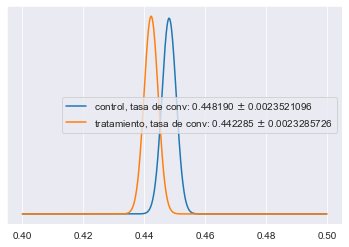

In [16]:
plot([beta_control, beta_tratamiento], ['control', 'tratamiento'])

In [17]:
# testeo para retention_7
gate_30 = df[df['version'] == 'gate_30']
gate_40 = df[df['version'] == 'gate_40']

impresiones_control = gate_30['retention_1'].count()
conversiones_control = gate_30['retention_1'][gate_30['retention_7'] == True].count()
impresiones_tratamiento = gate_40['retention_1'].count()
conversiones_tratamiento = gate_40['retention_1'][gate_40['retention_7'] == True].count()

In [18]:
# probabilidad de conversiones para test y control
prob_conversiones_control = conversiones_control / impresiones_control
prob_conversiones_tratamiento = conversiones_tratamiento / impresiones_tratamiento

In [19]:
# probabilidad de conversiones para test y control
prob_conversiones_control_7 = conversiones_control / impresiones_control
prob_conversiones_tratamiento_7 = conversiones_tratamiento / impresiones_tratamiento

In [20]:
# probabilidad de conversiones para test y control
prob_conversiones_control_7, prob_conversiones_tratamiento_7

(0.19020134228187918, 0.18200004396667327)

In [21]:
a_control, b_control = conversiones_control + 1, impresiones_control - conversiones_control + 1
a_tratamiento, b_tratamiento = conversiones_tratamiento + 1, impresiones_tratamiento - conversiones_tratamiento + 1
beta_control = beta(a_control, b_control)
beta_tratamiento = beta(a_tratamiento, b_tratamiento)

In [22]:
beta_control.mean(), beta_tratamiento.mean()

(0.19021520289919913, 0.18201402475214878)

In [23]:
x = np.linspace(0.17, 0.2, 1000)


def plot(betas, nombres):
    for bet, nom in zip(betas, nombres):
        y = bet.pdf(x)
        y_media = bet.mean()
        y_std = bet.std()

        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])

    plt.legend()
    plt.show();

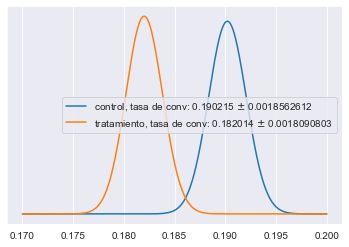

In [24]:
plot([beta_control, beta_tratamiento], ['control', 'tratamiento'])

In [25]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo
# Mis conclusiones:
# 1)